In [18]:
'''
input: None
output: all necessary packages for the notebook are imported
'''
# Import all necessery python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import seaborn as sns
from collections import defaultdict
import statsmodels.api as sm
import statsmodels.formula.api as smf
import swifter
from math import ceil
import pickle as pkl

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from IPython.display import Image
%matplotlib inline

## Read in the data

In [3]:
def read_in_data(sample):
    '''
    
    Reads in data from music_data folder in pickle format. If simple arguement is True, it limits each df to 1000
    randomly sampled rows.
    
    input: None
    output: df_train, df_members, df_full_songs
    '''
    
    # Limiting the data to 1000 records from each db
    df_train = pd.read_pickle('./music_data/train.pkl')
    df_members = pd.read_pickle('./music_data/members.pkl')
    df_full_songs = pd.read_pickle('./music_data/df_full_songs.pkl')
    
    if sample:
        df_train = df_train.sample(1000)
        df_members = df_members.sample(1000)
        df_full_songs = df_full_songs.sample(1000)
    
    return df_train, df_members, df_full_songs

In [4]:
def create_df_full_songs(df_song_extra,df_songs,df_isrc):
    '''
    input: df_song_extra,df_songs,df_isrc
    output: df_full_songs
    '''
    
    df_song_extra = pd.read_pickle('./music_data/song_extra_info.pkl')
    df_songs = pd.read_pickle('./music_data/songs.pkl')
    df_isrc = pd.read_pickle('./music_data/df_isrc.pkl')

    # To analyze song data, I am merging df_songs, df_songs_extra and df_isrc
    df_full_songs = (df_songs
                 .merge(df_songs,on='song_id',how='left')
                 .merge(df_song_extra,on='isrc',how='left')
                )

    # Deleting song data elements to save memory. Everything saved under df_full_songs
    del df_song_extra
    del df_songs
    del df_isrc

    # Write df_full_songs
    df_full_songs.to_pickle('./music_data/df_full_songs.pkl')

    return df_full_songs

## Feature engineering

In [5]:
def full_songs_engineering(df_full_songs):
    '''
    input: df_full_songs
    output: df_full_songs cleaned and engineered
    '''
    
    # Extract country of origin from isrc
    df_full_songs['song_language_isrc'] = np.where(df_full_songs['isrc'].isna(),
                                                   np.NaN,
                                                   df_full_songs['isrc'].astype(str).str[:2])
    
    # Count the number of genre_ids
    df_full_songs['count_genre_ids'] = df_full_songs['genre_ids'].str.count('\|')+1

    # Categorize genre (can be multiple)
    dfs=[]
    df_all_genres = pd.DataFrame(df_full_songs['genre_ids'].str.split('|',expand=True)).fillna(value=np.NaN)
    for i, column in enumerate(df_all_genres):
        dfs.append(pd.get_dummies(df_all_genres[i], prefix = 'genre_CAT'))
    df_genre_merged = pd.concat(dfs, axis=1)
    df_genre_merged = df_genre_merged.groupby(df_genre_merged.columns, axis=1).agg(np.max)
    df_full_songs = pd.concat([df_full_songs, df_genre_merged], axis=1)

    del df_genre_merged
    del df_all_genres
    del dfs
    
    return df_full_songs

In [6]:
def members_engineering(df_members):
    '''
    input: df_members
    output: df_members cleaned, and features engineered
    '''
    
    ## 'bd', aka age of user has outliers and bias
    # Replace ages >90 years with 90 years in df_members/user age
    df_members['bd'] = df_members['bd'].apply(lambda x: x if x<=90 else 90)

    # Replace ages <0 years with np.NaN in df_members/user age
    df_members['bd'] = df_members['bd'].apply(lambda x: x if x>=0 else np.NaN)

    # Replace 0s to np.NaN in df_members/user age
    df_members['bd'].replace(0,np.NaN,inplace=True)
    
    
    
    ## Formatting date columns
    df_members['registration_init_time'] = df_members['registration_init_time'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
    df_members['expiration_date'] = df_members['expiration_date'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
    
    # Calculate the time between user registration and today (ca. 2017-Jan-31)
    df_members['days_since_registration'] = df_members['registration_init_time'].apply(lambda x: (pd.to_datetime('20170131') - x).days)

    # Calculate the time between user expiration and today (ca. 2017-Jan-31)
    df_members['days_until_expiration'] = df_members['expiration_date'].apply(lambda x: (x - pd.to_datetime('20170131')).days)
    
    
    
    # Categorize "gender" on df_members
    gender_CAT = pd.get_dummies(df_members['gender'], prefix = 'gender_CAT')
    df_members = pd.concat([df_members, gender_CAT], axis=1)
    del gender_CAT
    
    
    
    # Calculate the difference between the age of the song and the age of the user (57% NaN ratio)
    df_members['days_since_registration'] = df_members['registration_init_time'].apply(lambda x: (pd.to_datetime('20170131') - x).days)
    
    return df_members

In [7]:
def train_engineering(df_train):
    '''
    input: df_train
    output: df_train cleaned and engineered
    '''
    
    # Categorize "screen of listening" on df_train (1: create screen_id, 2: categorize)
    df_train['screen_id'] = df_train['source_system_tab']+'+'+df_train['source_screen_name']+'+'+df_train['source_type']
    screen_id_CAT = pd.get_dummies(df_train['screen_id'], prefix = 'screen_id_CAT')
    df_train = pd.concat([df_train, screen_id_CAT], axis=1)
    del screen_id_CAT
    
    # Count number of songs each user has listened to
    df_activity_temp = pd.DataFrame(df_train.groupby(by='msno')['song_id'].nunique()).reset_index()
    df_activity_temp.columns = ['msno','user_activity']
    df_train = df_train.merge(df_activity_temp,how='left',on='msno')
    del df_activity_temp
    
    return df_train

In [8]:
def merge_databases(df_train, df_members, df_full_songs):
    '''
    input: df_train, df_members, df_full_songs
    output: df_merged
    '''
    
    df_merged = (df_train.merge(df_members, on='msno', how='left')
                 .merge(df_full_songs, on='song_id', how='left')
                )
    
    return df_merged

In [9]:
def merged_engineering(df_merged):
    '''
    input: df_merged
    output: df_merged cleaned and engineered
    
    Notes: this function is very very heavy. To run properly on large dfs, it requires AWS and chunkified dfs
    '''    
    
    # nth time listening to this artist
    msno_group = df_merged.groupby(by='msno')
    print('*** Group by done')
    
    KKBOX = np.array(msno_group['artist_name_x'].nunique())
    DEEZER = np.array(msno_group['artist_name_y'].nunique())
    print('*** Uniques found')
    
    df_artist_freq = pd.DataFrame({'msno':np.array(list(msno_group.groups.keys())),'artist_freq':np.where(KKBOX>DEEZER,KKBOX,DEEZER)})    
    df_artist_freq.columns = ['msno','artist_freq']
    print('*** Frequencies in df')
    
    print('*** Merge starting')
    df_merged = df_merged.merge(df_artist_freq,how='left',on='msno')
    print('*** Merge finished')
    
    del df_artist_freq
    
    # number of genres listened
    df_merged['genre_ids'] = df_merged['genre_ids'].str.replace('|',r',')
    print('*** Replace of | to , finished')
    df_grouped = (df_merged
                  .groupby('msno',as_index=False)
                  .agg({'genre_ids':(lambda x: x.str.cat(sep=',').split(','))})
                  .rename(columns={'genre_ids':'all_genres_listened'})
                 )
    print('*** Groupby finished')
    df_grouped['number_of_genres_listened'] = df_grouped['all_genres_listened'].swifter.apply(lambda x: len(set(x)))
    print('*** Set creation finished')
    
    print('*** Merge starting')
    df_merged = df_merged.merge(df_grouped, on='msno',how='left')
    print('*** Merge finished')
    
    del df_grouped
    
    print('Finished number of genres listened')
    
    # nth time listening to this genre - apply function
    def check_genres(row):
        counter = 0
        prev_counter = 0
        for item in row['all_genres_listened']:
            multi_counter = 0
            if ',' in str(row['genre_ids']):
                for genre in row['genre_ids'].split(','):
                    if item == genre:
                        multi_counter += 1
                        if prev_counter > multi_counter:
                            multi_counter = prev_counter
                    prev_counter = multi_counter
            else:
                if item == row['genre_ids']:
                    counter += 1
        return counter if counter > multi_counter else multi_counter

    # nth time listening to this genre - runner
    print('*** Starting nth time this genre')
    df_merged['n_th_time_this_genre'] = df_merged.swifter.apply(check_genres,axis=1)
    
    #del df_merged_test['all_genres_listened']
    #df_merged_test[df_merged_test.msno=='+3+6UDIIlqrd+JwTUBUX/6eQxl4bvbF3O3rsqt/gszs=']
    
    return df_merged

## MISC functions

In [10]:
def chunk(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# usage: for i, df_chunk in enumerate(chunk(df_merged_final, 100000)):

In [11]:
def get_user_split_data(df, chunksize = 100000):
    
    # list of unique users
    all_users = df['msno'].unique()
    number_of_users = all_users.shape[0]
    len_df = df.shape[0]
    chunknumbers = ceil(len_df / chunksize)
    userchunks = ceil(number_of_users/chunknumbers)
    
    df_chunks=[]
    for i in range(1,chunknumbers+1):
        print(f'Creating chunks {i} of {chunknumbers}')
        users_in_chunk = all_users[(i-1)*userchunks:i*userchunks]
        df_chunks.append(df[df['msno'].isin(users_in_chunk)])
    
    print('All chunks created')
    return df_chunks

In [12]:
def get_user_split_data_train_test(df_X, df_y, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df_X['msno'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    X_tr = df_X[~df_X['msno'].isin(test_users)]
    X_te = df_X[df_X['msno'].isin(test_users)]
    
    y_tr = df_y[~df_y['msno'].isin(test_users)]
    y_te = df_y[df_y['msno'].isin(test_users)]

    return X_tr, X_te, y_tr, y_te

In [13]:
# This unpickler was more reliable than pd.read_pickle
# filename = 'df_merged_merged_aws.pkl'

def own_read_pickle(filename):

    import pickle as pkl
    objects = []
    print(f'Pickle load of {filename} started')
    with (open(filename, 'rb')) as openfile:
        while True:
            try:
                objects.append(pkl.load(openfile))
            except EOFError:
                break

    df_output = objects[0]
    print(f'Pickle load of {filename} finished')
    return df_output

## Model building

#### 0. Create df_X by compiling 'useful' features and the target

In [14]:
def select_columns(df_in, target_removed=True):

    cols_not_required = ['song_id','source_system_tab','source_screen_name',
                        'source_type','gender','city','registered_via','registration_init_time',
                         'expiration_date','name','isrc','genre_ids','artist_name_x','composer',
                         'lyricist','language','track_title','album_title','artist_name_y',
                         'release_date','duration_sec','song_language_isrc','screen_id','all_genres_listened'
                        ]
    df_out = df_in.drop(cols_not_required,axis=1)
    
    if target_removed:
        df_out = df_out.drop(['target'],axis=1)
    
    return df_out

def load_dataset(filename, sample=False):
    
    df_merged = own_read_pickle(filename)
    print('load_dataset: df_merged loaded into memory')
    
    # Sample creation if needed
    if sample:
        list_of_chunks = get_user_split_data(df_merged,100000)
        df_sample = list_of_chunks[0]
        #df_sample = pd.read_pickle('df_sample_modeltraining.pkl')
        df_merged = df_sample
        print('load_dataset: sample creation done')
    
    df_X = select_columns(df_merged,target_removed=True).reset_index()
    df_X.rename({'index':'time_proxy'},axis=1,inplace=True)
    df_y = df_merged[['msno','target']]
    
    print('load_dataset: df_X,df_y created')
    
    return df_X, df_y

#### 1. Checking distribution of the target
It is apparent, that the target is evenly distributed, hence no class inbalance measures are required

In [40]:
y_train = pd.DataFrame(own_read_pickle('y_train.pkl'))
target_pcts = df_y['target'].value_counts(normalize=True) 
print(target_pcts)
target_pcts.plot(kind='bar')

Pickle load of y_train.pkl started


FileNotFoundError: [Errno 2] No such file or directory: 'y_train.pkl'

#### 2. Decide which scoring metric to optimize on
- target metrics have no imbalance
- it is not crucial to catch all 'positive' cases, nor are we interested in negative cases
- key is high **precision**, i.e. out of all offers we want the highest actual interesting ones
- however fully leaving recall out, would be biased
- score of choice: fbeta (beta = 1/3)

#### 3. Split into train-test-validation taking clustering into account (user based)

In [15]:
def split_data(df_X,df_y):
    # 20% for testing and 20% for validation
    # Getting: X_train, y_train + X_val, y_val + X_test, y_test
    X_train_val, X_test, y_train_val, y_test = get_user_split_data_train_test(df_X,df_y,test_size=0.2)
    X_train, X_val, y_train, y_val = get_user_split_data_train_test(X_train_val,y_train_val,test_size=0.25)
    print('split_data: train_test split on a user base finished')

    # Dropping msno columns, which was kept for user-based splitting
    X_train = X_train.drop(['msno'],axis=1)
    y_train = y_train.drop(['msno'],axis=1)
    X_val = X_val.drop(['msno'],axis=1)
    y_val = y_val.drop(['msno'],axis=1)
    X_test = X_test.drop(['msno'],axis=1)
    y_test = y_test.drop(['msno'],axis=1)

    y_train = np.array(y_train).reshape(y_train.size,)
    y_val = np.array(y_val).reshape(y_val.size,)
    y_test = np.array(y_test).reshape(y_test.size,)
    print('split_data: msno dropped, y-s reshaped')
    
    del df_X, df_y, X_train_val, y_train_val
    
    return X_train, y_train, X_val, y_val, X_test, y_test

#### 4. Do baseline model with few important features

In [16]:
def score_model(model, X, y, gbm=False):

    # Calculate hard predictions
    if gbm:
        prediction_hard = model.predict(X,ntree_limit=model.best_ntree_limit)
    else:
        prediction_hard = model.predict(X)
    print('score_model: Predictions ready')
    
    # Score model on FBeta weighing on precision
    beta=0.3
    print(f'FBeta(b={beta}) score is: {fbeta_score(y, prediction_hard,beta)}')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y, prediction_hard)
    TN, FP, FN, TP = conf_matrix.ravel()

    ## Scoring
    Recall = TP / (TP + FN)
    Precision=TP/(TP+FP)
    Specificity = TN / (TN + FP)
    Accuracy=(TP+TN)/(TP+TN+FP+FN)

    print('Accuracy:',Accuracy)
    print('Recall:',Recall)
    print('Precision:',Precision)
    print('Specificity:',Specificity)

    # Print confusion matrix
    return pd.DataFrame(conf_matrix, columns=
                 ['Predict (0=no relisten)', 'Predict (1=relisten)'],
                 index=['Actual (0=no relisten)', 'Actual (1=relisten)'])

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

X_train_small = X_train[['user_activity','artist_freq','number_of_genres_listened','n_th_time_this_genre']].astype(float)
X_val_small = X_val[['user_activity','artist_freq','number_of_genres_listened','n_th_time_this_genre']].astype(float)

# Scale X_train to same scale
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train_small)
X_val_scaled = std_scale.fit_transform(X_val_small)

# Apply logistic regression
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train_scaled, y_train)

score_model(lr, X_val_scaled, y_val)

FBeta(b=0.3) score is: 0.8145705294249105
Accuracy: 0.5380899961808909
Recall: 0.8510212418300653
Precision: 0.5519114101782923
Specificity: 0.1556931063744821


,Predict (0=no relisten),Predict (1=relisten)
Actual (0=no relisten),3119,16914
Actual (1=relisten),3647,20833


#### 4b. Check pairplots if linear separation is possible

/Users/krisztian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/krisztian/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/krisztian/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/krisztian/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, ou

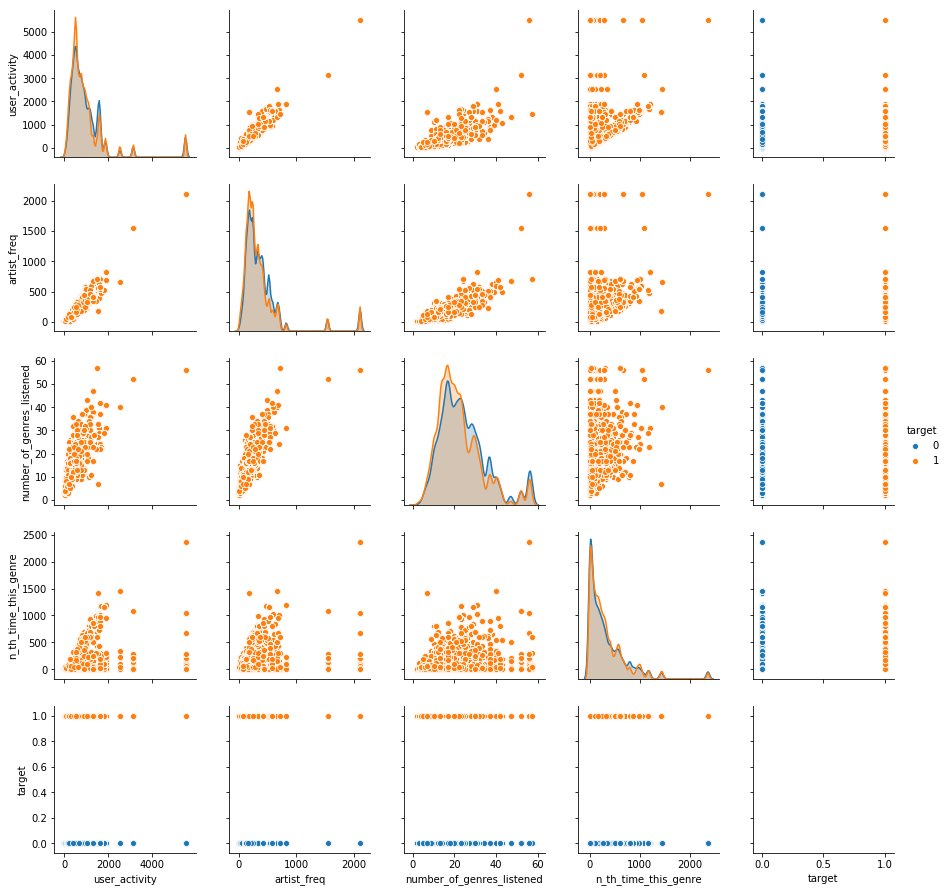

In [102]:
sns.pairplot((select_columns
              (df_sample,target_removed=False)
              [['user_activity','artist_freq','number_of_genres_listened','n_th_time_this_genre','target']]), 
             hue='target')

#### 5a. Tree based models
Switch to tree-based methods given low (accuracy) scores in logistic regression, clear bias towards positive predictions, and low visible separatability inferrable from the pairplots

In [20]:
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [21]:
# Select dataframes

X_train_small = X_train[['user_activity','artist_freq','number_of_genres_listened','n_th_time_this_genre']].astype(float)
X_val_small = X_val[['user_activity','artist_freq','number_of_genres_listened','n_th_time_this_genre']].astype(float)

In [23]:
# Random forest for baseline

rf = RandomForestClassifier(n_estimators = 1000, max_features = 3, min_samples_leaf = 4, n_jobs=-1)
rf.fit(X_train_small,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
# Random forest scoring
score_model(rf, X_val_small, y_val)

FBeta(b=0.3) score is: 0.797741149918771
Accuracy: 0.5452789072855121
Recall: 0.8297794117647059
Precision: 0.5582488251298541
Specificity: 0.19762392053112365


,Predict (0=no relisten),Predict (1=relisten)
Actual (0=no relisten),3959,16074
Actual (1=relisten),4167,20313


In [152]:
# Gradient boosting

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.005, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        n_jobs=-1
                       )

eval_set=[(X_train_small,y_train),(X_val_small,y_val)]
fit_model = gbm.fit( 
                    X_train_small, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

score_model(gbm, X_val_small, y_val)

FBeta(b=0.3) score is: 0.9040621810095893
Accuracy: 0.554849145193539
Recall: 0.9582516339869281
Precision: 0.5552057939457055
Specificity: 0.061897868516947036


,Predict (0=no relisten),Predict (1=relisten)
Actual (0=no relisten),1240,18793
Actual (1=relisten),1022,23458


#### 5b. Extending the model

In [7]:
def tree_modelrun(X_train,y_train,X_val,y_val, xgb, select_thresh=0,select_model=None):
    
    if xgb:
        
        if select_thresh>0:
            from sklearn.feature_selection import SelectFromModel
            selection = SelectFromModel(select_model, threshold=select_thresh, prefit=True)
            X_train = selection.transform(X_train)
            X_val = selection.transform(X_val)
        
        # Gradient boosting

        model = xgb.XGBClassifier( 
                                n_estimators=30000,
                                max_depth=12,
                                objective='binary:logistic', #new objective
                                learning_rate=.01, 
                                subsample=.8,
                                min_child_weight=4,
                                colsample_bytree=.2,
                                n_jobs=-1
                               )

        eval_set=[(X_train,y_train),(X_val,y_val)]
        fit_model = model.fit( 
                            X_train, y_train, 
                            eval_set=eval_set,
                            eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                            early_stopping_rounds=50,
                            verbose=True
                           )
    else:
        # Random forest for baseline

        model = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
        model.fit(X_train,y_train)

    print(score_model(model, X_val, y_val))
    
    return model

In [41]:
def param_importance(gbm,num):
    gain = gbm.get_booster().get_score(importance_type='gain')
    return xgb.plot_importance(gbm,max_num_features=num), xgb.plot_importance(gbm, importance_type='gain',max_num_features=num), gain

## -- MAIN --

In [30]:
def feature_engineering():
    start = time.time()
    print('starting',start)

    df_train, df_members, df_full_songs = read_in_data(sample=True)
    print('Data loaded. Elapsed:',round((time.time() - start)/60,1),'minutes')

    df_merged = merge_databases(df_train, df_members, df_full_songs)
    print('df_merged created',round((time.time() - start)/60,1),'minutes')
    df_merged.to_pickle('df_merged_premod.pkl',protocol=3)
    print('df_merged premod pickled',round((time.time() - start)/60,1),'minutes')

    del df_train, df_members, df_full_songs
    print('individual dfs deleted',round((time.time() - start)/60,1),'minutes')

    df_merged = full_songs_engineering(members_engineering(train_engineering(df_merged)))

    dfs=[]
    all_chunks = get_user_split_data(df_merged,100000)
    number_of_chunks = len(all_chunks)

    for i, df_chunk in enumerate(all_chunks):
        print(f'initiating chunk number {i} of {number_of_chunks}')
        dfs.append(merged_engineering(df_chunk))
        print(f'finished chunk number {i} of {number_of_chunks} in',round((time.time() - start)/60,1),'minutes')

    with open('merged_engineered_list_preconcat.pkl', 'wb') as handle:
        pkl.dump(dfs, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print(f'list pkl saved',round((time.time() - start)/60,1),'minutes')    

    print(f'concat starting at',round((time.time() - start)/60,1),'minutes')
    df_merged_postmod = pd.concat(dfs)
    print(f'concat finished at',round((time.time() - start)/60,1),'minutes')

    print(f'pickle starting at',round((time.time() - start)/60,1),'minutes')
    df_merged_postmod.to_pickle('df_merged_final_postmod.pkl',protocol=3)
    print(f'pickle finished at',round((time.time() - start)/60,1),'minutes')

    print(f'Script finished in',round((time.time() - start)/60,1),'minutes')
    print('*'*50)

In [71]:
def model_creation():
    start = time.time()
    start_format = time.strftime("%Y%m%d-%H%M%S")
    print(f'model_creation() started {start_format}')
    
    print('*'*25,' load_dataset initializing ','*'*10,round((time.time() - start)/60,1),'minutes')
    df_X, df_y = load_dataset('df_merged_final_postmod_aws.pkl', sample=False)
    print('*'*25,' load_dataset finished ','*'*10,round((time.time() - start)/60,1),'minutes')
    
    print('*'*25,' split_data initializing ','*'*10,round((time.time() - start)/60,1),'minutes')
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_X,df_y)
    print('*'*25,' split_data finished ','*'*10,round((time.time() - start)/60,1),'minutes')
    del df_X, df_y
    
    X_train = X_train.astype(float)
    X_val = X_val.astype(float)
    X_test = X_test.astype(float)
    
    print('*'*25,' xgboost_modelrun initializing ','*'*10,round((time.time() - start)/60,1),'minutes')
    gbm2 = xgboost_modelrun(X_train,y_train,X_val,y_val)
    print('*'*25,' xgboost_modelrun finished ','*'*10,round((time.time() - start)/60,1),'minutes')
    
    # save the model to disk
    print('*'*25,' pickle initializing ','*'*10,round((time.time() - start)/60,1),'minutes')
    filename = time.strftime("%Y%m%d-%H%M%S") + '_xgb_aws_model.sav'
    pkl.dump(gbm2, open(filename, 'wb'))
    print('*'*25,' pickle finished ','*'*10,round((time.time() - start)/60,1),'minutes')
    print('*'*50)
    print('*'*25,' model_creation() finished ','*'*10,round((time.time() - start)/60,1),'minutes')

In [130]:
del df_full_songs

In [129]:
#df_full_songs = pd.read_pickle('./music_data/df_full_songs.pkl')
#df_full_songs[np.where((np.array(df_full_songs.genre_ids.str.contains('94')==True) ^ np.array(df_full_songs.genre_ids.str.contains('940')==True) ^ np.array(df_full_songs.genre_ids.str.contains('947')==True)),True,False)]
df_full_songs[np.where((np.array(df_full_songs.genre_ids.str.contains('698')==True)),True,False)]

,song_id,name,isrc,song_length,genre_ids,artist_name_x,composer,lyricist,language,track_title,album_title,artist_name_y,release_date,duration_sec,track_pos,bpm,gain,rank
543,mcdW2f3klQ0ZRZJgZT8i0bRYs4u7ZF+nbud95tfeF+Q=,Christmas Island,FR6V80490285,157802.0,698,Various Artists,DR.,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615,p9MTGzYR6rTT5xBbBiJUs0UR9PXmVYKAbvgkm4ExaIQ=,The Christmas Song,IT0411601120,212323.0,698,Perry Como,Robert Wells,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3436,WU23wlPRnHdtXoz6cVh+YSyoxLPyEl+Gkhnxk31gNVs=,Silent Night,GBURZ1001285,150778.0,698,Frank Sinatra,E. Bergdahl,E. Bergdahl,52.0,Silent Night,Christmas Day,Frank Sinatra,2017-12-08,150,18,0,0,17771
4703,sa1CYRCzC8cF876yjJMfu6zm25hrDsr+zxpYsmwIHvY=,Away in a Manger,FR6V82085999,121301.0,698,Ella Fitzgerald| Nat King Cole,Traditional,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5681,KR9D5ySmfFXcl9OIemFJtXKjR2ODANswl+qluy9spaA=,The Little Drummer Boy,ITC091400438,152044.0,698,Various Artists,Honorati| Simeone| Davis,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7965,Gm1U6hNBfBXjmIpAFl6yxOPqgp6KXYdzqxAl5/MaJA8=,The Christmas Song (Chestnuts Roasting on an O...,GBURZ0800041,211957.0,698,Frank Sinatra,Mel Torme,Mel Torme,52.0,The Christmas Song (Chestnuts Roasting On An O...,The Kings of Christmas,Frank Sinatra,2014-10-15,211,2,127,-15.2,23501
10343,Q3rNtT7Ai2YhkgMf8/9P6SScEiUus1pgY4NMQSUEg/0=,Coffee: Arab Dance,FR6V82136751,278918.0,698,Tchaikovsky's Nutcracker,Pyotr Ilyich Tchaikovsky,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10434,M3m6F2PwGLxZhmXKA17rvZRERhk3o5eFoRAQ2lp4RcY=,O Little Town Of Bethlehem,DEPZ68938685,186224.0,698,Frank Sinatra,Phillips Brooks| Lewis Redner,NaN,52.0,O Little Town Of Bethlehem,Christmas Bells Are Ringing,Frank Sinatra,2014-10-15,186,7,131,-8.7,710
10955,A5UCHl5Opb8Xbu9ADAfDbEJfDkZmFjjgR1NQaSkXCpg=,White Christmas,ITC091400427,160217.0,698,Various Artists,Berlin,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10969,RNc2IEbIrEWUoFcIMJOchX0B0F8J+6XuUs3KOcRwfSc=,O Holy Night,DEPZ60237484,173035.0,698,Nat King Cole,Adolphe Adam| John Sullivan Dwight,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
model_log = pkl.load(open("20181029-204345_logextended_aws_model.sav", "rb"))
#model_xgb = pkl.load(open("20181029-155308_xgb_aws_model(full v4).sav", "rb"))
key = list(score_dict.keys())
#col
value = list(model.coef_[0])



a =[(k,v) for (v,k) in sorted(zip(value,key),reverse=True, key=lambda t: abs(t[0]))]
a

[('screen_id_CAT_listen with+Others profile more+listen-with',
  -0.22791696762333702),
 ('screen_id_CAT_search+Local playlist more+local-library',
  0.11799585668739312),
 ('screen_id_CAT_discover+Discover Genre+online-playlist',
  0.10731407397053627),
 ('screen_id_CAT_listen with+Radio+radio', -0.06942732531606728),
 ('screen_id_CAT_discover+Discover Chart+song-based-playlist',
  -0.06769255728504059),
 ('screen_id_CAT_my library+My library+listen-with', 0.06096463703658014),
 ('genre_CAT_94', -0.05977888106016205),
 ('screen_id_CAT_my library+Album more+local-playlist', 0.05954342071674719),
 ('genre_CAT_698', 0.058460530082784054),
 ('screen_id_CAT_listen with+Album more+album', -0.05030260143947857),
 ('screen_id_CAT_discover+Discover Feature+radio', -0.04682135767237713),
 ('rank', -0.04647777722906813),
 ('screen_id_CAT_search+Others profile more+listen-with',
  -0.03985498294835426),
 ('screen_id_CAT_my library+Discover Feature+online-playlist',
  -0.03978203869995894),
 ('scr

In [56]:
#score_dict = model.get_booster().get_score(importance_type='gain')
ks = []
vs = []
for k,v in score_dict.items():
    ks.append(k)
    vs.append(v)

a =pd.DataFrame([(k,v) for (v,k) in sorted(zip(vs,ks),reverse=True)])
a.to_clipboard()

In [17]:
def final_scoring():
    start = time.time()
    start_format = time.strftime("%Y%m%d-%H%M%S")
    print(f'model_creation() started {start_format}')
    
    X_test = own_read_pickle('X_test.pkl')
    y_test = own_read_pickle('y_test.pkl')
    
    y_test = y_test[~X_test.isnull().any(axis=1)]
    X_test = X_test.dropna()
    with open('X_test_dropna.pkl', 'wb') as handle:
        pkl.dump(X_test, handle, protocol=pkl.HIGHEST_PROTOCOL)
    with open('y_test_dropna.pkl', 'wb') as handle:
        pkl.dump(y_test, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
    X_train = own_read_pickle('X_train_dropna.pkl')
    y_train = own_read_pickle('y_train_dropna.pkl')

    print('*'*50,round((time.time() - start)/60,1),'minutes')
    ## 1. Logistic regression - baseline
    print('Logistic regression baseline')
    X_train_small = pd.DataFrame(X_train['screen_id_CAT_my library+Local playlist more+local-playlist'])
    X_test_small = pd.DataFrame(X_test['screen_id_CAT_my library+Local playlist more+local-playlist'])
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train_small, y_train)
    print(score_model(lr, X_test_small, y_test))
    filename = time.strftime("%Y%m%d-%H%M%S") + '_logbaseline_aws_model.sav'
    pkl.dump(lr, open(filename, 'wb'))
    del lr
    print(f'Saved as {filename}')

def othermodels():    
    print('*'*50,round((time.time() - start)/60,1),'minutes')
    ## 2. Logistic regression - extended
    print('Logistic regression extended')
    std_scale = StandardScaler()
    X_train_scaled = std_scale.fit_transform(X_train)
    X_test_scaled = std_scale.fit_transform(X_test)
    lr2 = LogisticRegression(solver='lbfgs')
    lr2.fit(X_train_scaled, y_train)
    print(score_model(lr2, X_test_scaled, y_test))
    filename = time.strftime("%Y%m%d-%H%M%S") + '_logextended_aws_model.sav'
    pkl.dump(lr2, open(filename, 'wb'))
    del lr2
    print(f'Saved as {filename}')
    
    print('*'*50,round((time.time() - start)/60,1),'minutes')
    ## 3. Random forest model
    print('Random forest extended')
    rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    rf.fit(X_train,y_train)
    print(score_model(rf, X_test, y_test))
    filename = time.strftime("%Y%m%d-%H%M%S") + '_RF_aws_model.sav'
    pkl.dump(rf, open(filename, 'wb'))
    del rf
    print(f'Saved as {filename}')
    
    print('*'*50,round((time.time() - start)/60,1),'minutes')
    ## 4. Final xgboost model
    print('XGBoost final')
    xgb = pkl.load(open("20181029-155308_xgb_aws_model(full v4).sav", "rb"))
    print(score_model(xgb, X_test, y_test))
    print(f'Saved as 20181029-155308_xgb_aws_model(full v4).sav')

Pickle load of X_test.pkl started


FileNotFoundError: [Errno 2] No such file or directory: 'X_test.pkl'

## Deezer downloader

In [ ]:
def downloader(df_merged):
    '''
    Download data from deezer

    input: df_merged
    otuput: dict containing the API download data
    '''

    BASE_URL = 'https://api.deezer.com/2.0/track/isrc:'
    unique_isrc = df_merged['isrc'].unique()
    total = len(unique_isrc)
    from IPython.display import clear_output, display

    for i, isrc in enumerate(unique_isrc):
        if not dict[str(isrc)]:
            clear_output(wait=True)
            try:            
                api_call = BASE_URL + str(isrc)
                r = req.get(api_call).content
                dict[str(isrc)] = r
                print('Saved:',str(isrc),i,'of',total)
            except:
                print('***Failed:***',str(isrc),i,'of',total)
                downloader(df_merged)

In [27]:
def save_deezer_to_pickle(dict):
    '''
    input: dict with downloaded deezer api info
    output: none, saves dict to pickle
    '''    
    # Save the downloaded data to a pkl file
    with open('deezer_data.pkl', 'wb') as handle:
        pickle.dump(dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
def deezer_into_df(dict):    
    '''
    Take the dict with the downloaded API data

    input: dict with downloaded api info
    output: df_isrc in memory and saved to disk, containing the useful info from 

    '''
    import json
    dfs=[]
    for key, value in dict.items():
        json1_data = json.loads(value)

        try:
            isrc_query = np.array([
                key,
                json1_data['title'],
                json1_data['album']['title'],
                json1_data['artist']['name'],
                json1_data['release_date'],
                json1_data['duration'],
                json1_data['track_position'],
                json1_data['bpm'],
                json1_data['gain'],
                json1_data['rank']
                                  ])
            df_isrc_query = pd.DataFrame(isrc_query.reshape(1,isrc_query.size))
            dfs.append(df_isrc_query)
        except:
            try:
                if json1_data['error']['code'] == 800:
                    pass #all response 800 just pass
            except:
                print(key,'/n', json1_data)
                pass
    df_isrc_all = pd.concat(dfs)
    df_isrc_all.columns = ['isrc','track_title','album_title','artist_name','release_date','duration_sec','track_pos','bpm','gain','rank']
    df_isrc_all.reset_index(inplace=True)
    del df_isrc_all['index']
    df_isrc_all.to_pickle('df_isrc.pkl')
    
    return df_isrc_all

In [18]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, str(sys.getsizeof(globals().get(x))//2**10//2**10) + ' MB') for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: int(x[1].split(' ')[0]), reverse=True)

[('BeautifulSoup', '0 MB'),
 ('GeocoderTimedOut', '0 MB'),
 ('Image', '0 MB'),
 ('KFold', '0 MB'),
 ('Lasso', '0 MB'),
 ('LassoCV', '0 MB'),
 ('LinearRegression', '0 MB'),
 ('Nominatim', '0 MB'),
 ('Pipeline', '0 MB'),
 ('PolynomialFeatures', '0 MB'),
 ('Ridge', '0 MB'),
 ('RidgeCV', '0 MB'),
 ('StandardScaler', '0 MB'),
 ('UserAgent', '0 MB'),
 ('defaultdict', '0 MB'),
 ('full_songs_engineering', '0 MB'),
 ('lars_path', '0 MB'),
 ('mdates', '0 MB'),
 ('mean_absolute_error', '0 MB'),
 ('mean_squared_error', '0 MB'),
 ('members_engineering', '0 MB'),
 ('merge_databases', '0 MB'),
 ('merged_engineering', '0 MB'),
 ('np', '0 MB'),
 ('objects', '0 MB'),
 ('openfile', '0 MB'),
 ('pd', '0 MB'),
 ('pkl', '0 MB'),
 ('plt', '0 MB'),
 ('read_in_data', '0 MB'),
 ('req', '0 MB'),
 ('sm', '0 MB'),
 ('smf', '0 MB'),
 ('sns', '0 MB'),
 ('train_engineering', '0 MB'),
 ('train_test_split', '0 MB'),
 ('urljoin', '0 MB'),
 ('webdriver', '0 MB')]

# Not in use

In [ ]:
# Not is use due to speed issues

import time

start = time.time()
df_train, df_members, df_full_songs = read_in_data(sample=False)
print('Data loaded. Elapsed:',round((time.time() - start)/60,1),'minutes')

df_full_songs = full_songs_engineering(df_full_songs)
print('df_full_songs modified',round((time.time() - start)/60,1),'minutes')

df_members = members_engineering(df_members)
print('df_members modified',round((time.time() - start)/60,1),'minutes')

df_train = train_engineering(df_train)
print('df_train modified',round((time.time() - start)/60,1),'minutes')

df_merged = merge_databases(df_train, df_members, df_full_songs)
print('df_merged created',round((time.time() - start)/60,1),'minutes')
df_merged.to_pickle('df_merged_premod_aws.pkl',protocol=3)
print('df_merged premod pickled',round((time.time() - start)/60,1),'minutes')

df_merged = merged_engineering(df_merged)
print('df_merged modified and pickled',round((time.time() - start)/60,1),'minutes')
df_merged.to_pickle('df_merged_mod_aws.pkl',protocol=3)
print('df_merged mod pickled',round((time.time() - start)/60,1),'minutes')

In [ ]:
df_merged = full_songs_engineering(df_merged)
print('songs engineered',round((time.time() - start)/60,1),'minutes')
df_merged.to_pickle('df_merged_songs_aws.pkl',protocol=3)
print('df_merged_songs_aws premod pickled',round((time.time() - start)/60,1),'minutes')

df_merged = members_engineering(df_merged)
print('members engineered',round((time.time() - start)/60,1),'minutes')
df_merged.to_pickle('df_merged_members_aws.pkl',protocol=3)
print('df_merged_members_aws premod pickled',round((time.time() - start)/60,1),'minutes')

df_merged = train_engineering(df_merged)
print('train engineered',round((time.time() - start)/60,1),'minutes')
df_merged.to_pickle('df_merged_merged_aws.pkl',protocol=3)
print('df_merged_merged_aws premod pickled',round((time.time() - start)/60,1),'minutes')

df_merged = merged_engineering(df_merged)
print('merged engineered',round((time.time() - start)/60,1),'minutes')

In [39]:
a = pd.DataFrame([1,2,3,4,np.NaN],[1,2,np.NaN,4,1]).reset_index()
b = np.array([1,2,3,4,5])
~a.isnull().any(axis=1)
b[~a.isnull().any(axis=1)]

array([1, 2, 4])